In [1]:
import os
from PIL import Image
from pydicom import dcmread
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

C:\Users\ASUS\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\ASUS\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def read_list(path):
    with open(path) as file:
        lines = file.readlines()
    data = [line.strip() for line in lines]
    return data

In [3]:
def visualize(image):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

In [4]:
class CovidPNGCtDataset(Dataset):
    def __init__(self, covid_dir, nonCovid_dir, list_COVID, list_NonCOVID, 
                 transform=None, is_load_to_ram=False, is_concat_lung=False, is_cap=False):
        self.is_load_to_ram = is_load_to_ram
        self.is_concat_lung = is_concat_lung
        self.is_cap = is_cap

        self.covid_dir = covid_dir
        self.nonCovid_dir = nonCovid_dir
    
        self.transform = transform
    
        self.images = []
        self.lung_masks = []
        self.lesion_masks = []
        self.labels = []

        images_covid = read_list(list_COVID)
        images_nonCovid = read_list(list_NonCOVID)
        print("[INFO] Covid Size", len(images_covid))
        print("[INFO] None Covid Size", len(images_nonCovid))
        
        for image in images_covid:
            self.images.append(os.path.join(self.covid_dir, 'Covid', image))
            self.lung_masks.append(os.path.join(self.covid_dir, 'Covid_LungMask', image))
            self.lesion_masks.append(os.path.join(self.covid_dir, 'Covid_LesionMask', image))
            self.labels.append(1)
            
        for image in images_nonCovid:
            if not self.is_cap:
                self.images.append(os.path.join(self.nonCovid_dir, 'Normal', image))
                self.lung_masks.append(os.path.join(self.nonCovid_dir, 'Normal_LungMask', image))
            else:
                self.images.append(os.path.join(self.nonCovid_dir, 'CAP', image))
                self.lung_masks.append(os.path.join(self.nonCovid_dir, 'CAP_LungMask', image))
            self.lesion_masks.append(None)
            self.labels.append(0)
        
        # self.is_load_to_ram = True
        if self.is_load_to_ram:
            self.loaded_images = []
            self.loaded_lung_masks = []
            self.loaded_lesion_masks = []
            for index in tqdm(range(len(self.images))):
                image, lung_mask, lesion_mask = self.__load_data__(index)
                self.loaded_images.append(image)
                self.loaded_lung_masks.append(lung_mask)
                self.loaded_lesion_masks.append(lesion_mask)
        
        self.__check_validation__()
        
    def __load_data__(self, index):
        image = np.array(Image.open(self.images[index]).convert("RGB"))    
    
        lung_mask = np.array(Image.open(self.lung_masks[index]).convert("L"), dtype=np.float32)
        lung_mask[lung_mask < 127] = 0.0
        lung_mask[lung_mask >= 127] = 1.0

        if self.lesion_masks[index] is not None:
            lesion_mask = np.array(Image.open(self.lesion_masks[index]).convert("L"), dtype=np.float32)
        else:
            lesion_mask = np.zeros_like(lung_mask, dtype=np.float32)
        lesion_mask[lesion_mask < 127] = 0.0
        lesion_mask[lesion_mask >= 127] = 1.0

        return image, lung_mask, lesion_mask
        
    def __check_validation__(self):
        if len(self.images) == len(self.labels):
            print("[INFO] Dataset Size:", self.__len__())
            print("[INFO] Dataset checked OK!")
        else:
            print("[INFO] Dataset checked invalid!")
                
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        if not self.is_load_to_ram:
            image, lung_mask, lesion_mask = self.__load_data__(index)
        else:
            image = np.copy(self.loaded_images[index])
            lung_mask = np.copy(self.loaded_lung_masks[index])
            lesion_mask = np.copy(self.loaded_lesion_masks[index])
                
        label = self.labels[index]
        
        if label == 1 and np.sum(lesion_mask) == 0:
            print("_________________________Invalid Mask for Covid____________________________________")
        if label == 0 and np.sum(lesion_mask) != 0:
            print("_________________________Invalid Mask for NonCovid____________________________________")
        
        if self.transform is not None:
            augmentations = self.transform(image=image, lung_mask=lung_mask, lesion_mask=lesion_mask)
      
            image = augmentations["image"]
            lung_mask = augmentations["lung_mask"]
            if self.is_concat_lung:
                image = torch.cat((image, lung_mask.unsqueeze(0)), dim=0)
      
            mask = augmentations["lesion_mask"]

        return image, label, mask 

[INFO] Covid Size 349
[INFO] None Covid Size 222
[INFO] Dataset Size: 571
[INFO] Dataset checked OK!
tensor(1.) tensor(0.)


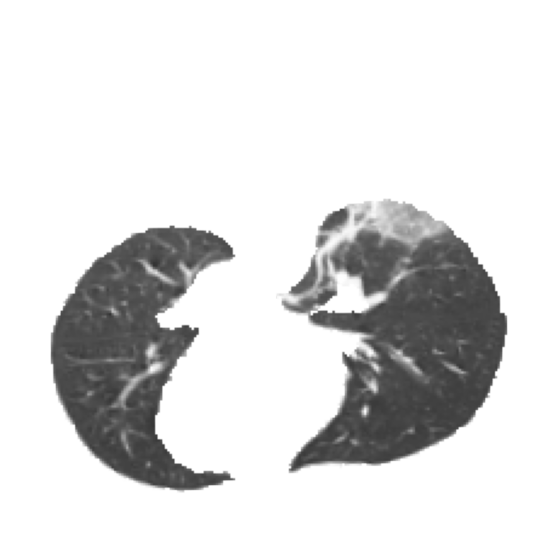

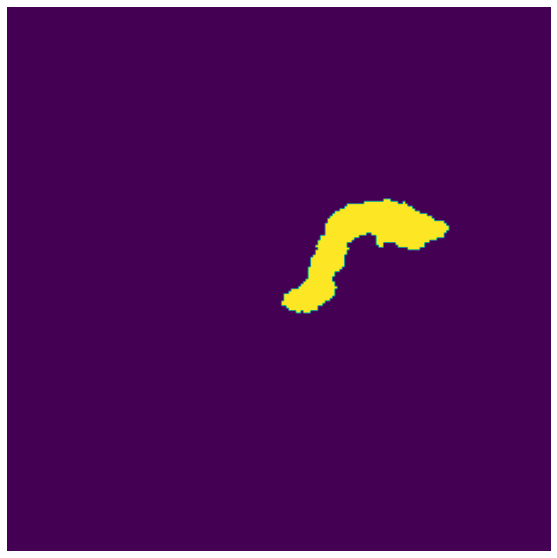

In [5]:
# test CovidPNGCtDataset
if __name__ == "__main__":
    !pip install albumentations==0.4.6
    import albumentations as A
    import cv2
    from albumentations.pytorch import ToTensorV2
    from torchvision import transforms

    train_transformer = A.Compose([
        A.Resize(height=256, width=256, interpolation=cv2.INTER_AREA),
        A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1.0), interpolation=cv2.INTER_AREA),
        A.HorizontalFlip(),
        A.Rotate(limit=15),
        A.GaussNoise(),
        A.GaussianBlur(blur_limit=5),
        A.RandomContrast(limit=0.2),
        A.RandomBrightness(limit=0.2),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2()
        ],
        additional_targets={'lung_mask': 'mask', 'lesion_mask': 'mask'},
    )

    testDataset = CovidPNGCtDataset(
          covid_dir= r'D:\YSC2023\Implementation\Dataset_PNG\COVID',
          nonCovid_dir=r'D:\YSC2023\Implementation\Dataset_PNG\NONCOVID',
          list_COVID=r'D:\YSC2023\Implementation\Dataset_PNG\covid_test.txt',
          list_NonCOVID=r'D:\YSC2023\Implementation\Dataset_PNG\normal_test.txt',
          transform=train_transformer,
          is_concat_lung=True)

    image, label, mask = testDataset.__getitem__(0)
    print(image.max(), image.min())
    visualize(transforms.ToPILImage()(image))
    visualize(transforms.ToPILImage()(mask))

In [6]:
class CovidHUCtDataset(CovidPNGCtDataset):
    def __init__(self, covid_dir, nonCovid_dir, list_COVID, list_NonCOVID, 
                 transform=None, is_load_to_ram=False, is_concat_lung=False, is_cap=False):
        super(CovidHUCtDataset, self).__init__(covid_dir=covid_dir, nonCovid_dir=nonCovid_dir, list_COVID=list_COVID, list_NonCOVID=list_NonCOVID, 
                                               transform=transform, is_load_to_ram=is_load_to_ram, is_concat_lung=is_concat_lung, is_cap=is_cap)
    
    def __load_data__(self, index):
        lower = -1000
        upper = -100

        image = (dcmread(self.images[index]).pixel_array).astype('float32')
        image[image < lower] = lower
        image[image > upper] = upper
        image = image - lower    

        image = np.expand_dims(image, axis=-1)
        image = np.concatenate((image, image, image), axis=2)

        lung_mask = (dcmread(self.lung_masks[index]).pixel_array).astype('float32')
        
        if self.lesion_masks[index] is not None:
            lesion_mask = (dcmread(self.lesion_masks[index]).pixel_array).astype('float32')
        else:
            lesion_mask = np.zeros_like(lung_mask, dtype=np.float32)
            
        return image, lung_mask, lesion_mask


[INFO] Covid Size 275
[INFO] None Covid Size 174
[INFO] Dataset Size: 449
[INFO] Dataset checked OK!
tensor(1.) tensor(0.)


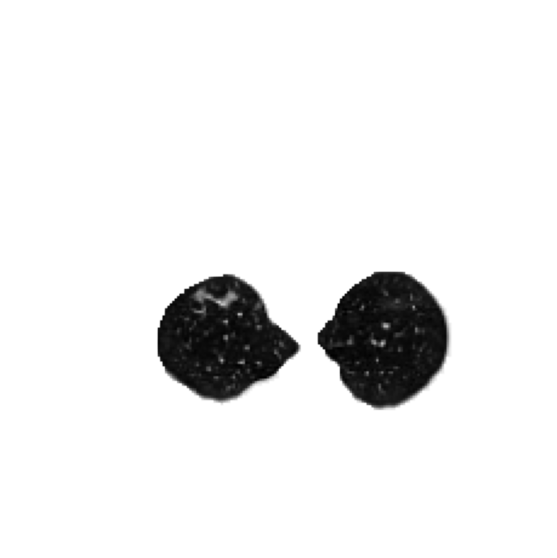

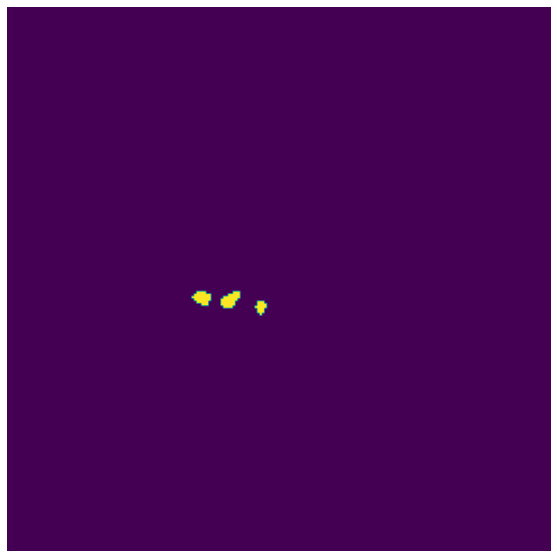

In [7]:
# test CovidHUCtDataset
if __name__ == "__main__":
    !pip install albumentations==0.4.6
    import albumentations as A
    import cv2
    from albumentations.pytorch import ToTensorV2
    from torchvision import transforms
    
    train_transformer = A.Compose([
        A.ToFloat(max_value=900.0),
        A.Resize(height=256, width=256, interpolation=cv2.INTER_AREA),
        A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1.0), interpolation=cv2.INTER_AREA),
        A.HorizontalFlip(),
        A.Rotate(limit=15),
        # A.GaussNoise(),
        A.GaussianBlur(blur_limit=5),
        A.RandomContrast(limit=0.2),
        A.RandomBrightness(limit=0.2),
        # A.FromFloat(max_value=900.0),
        # A.Normalize(
        #     mean=[0.0, 0.0, 0.0],
        #     std=[1.0, 1.0, 1.0],
        #     max_pixel_value=900.0,
        # ),
        ToTensorV2()
        ],
        additional_targets={'lung_mask': 'mask', 'lesion_mask': 'mask'},
      )

    testDataset = CovidHUCtDataset(
        covid_dir=r'D:\YSC2023\Implementation\Dataset\COVID',
        nonCovid_dir=r'D:\YSC2023\Implementation\Dataset\NONCOVID',
        list_COVID=r'D:\YSC2023\Implementation\Dataset\covid_test.txt',
        list_NonCOVID=r'D:\YSC2023\Implementation\Dataset\normal_test.txt',
        transform=train_transformer,
        is_concat_lung=True
    )
    image, label, mask = testDataset.__getitem__(6)
    print(image.max(), image.min())
    visualize(transforms.ToPILImage()(image))
    visualize(transforms.ToPILImage()(mask))

In [9]:
def get_png_data_loader(
    covid_dir,
    nonCovid_dir,
    train_list_COVID,
    train_list_NonCOVID,
    train_transformer,
    val_list_COVID,
    val_list_NonCOVID,
    val_transformer,
    test_list_COVID,
    test_list_NonCOVID,
    batch_size,
    is_load_to_ram,
    is_concat_lung, 
    is_cap,
):

    print("[INFO] PNG")
    print("[INFO] Loading train dataset ...")
    train_dataset = CovidPNGCtDataset(covid_dir=covid_dir,
                                    nonCovid_dir=nonCovid_dir, 
                                    list_COVID=train_list_COVID,
                                    list_NonCOVID=train_list_NonCOVID,
                                    transform=train_transformer,
                                    is_load_to_ram=is_load_to_ram,
                                    is_concat_lung=is_concat_lung,
                                    is_cap=is_cap)
    print("[INFO]")

    print("[INFO] Loading validation dataset ...")
    val_dataset = CovidPNGCtDataset(covid_dir=covid_dir,
                                  nonCovid_dir=nonCovid_dir, 
                                  list_COVID=val_list_COVID,
                                  list_NonCOVID=val_list_NonCOVID,
                                  transform=val_transformer,
                                  is_load_to_ram=is_load_to_ram,
                                  is_concat_lung=is_concat_lung,
                                  is_cap=is_cap)
    print("[INFO]")

    print("[INFO] Loading test dataset ...")
    test_dataset = CovidPNGCtDataset(covid_dir=covid_dir,
                                  nonCovid_dir=nonCovid_dir, 
                                  list_COVID=test_list_COVID,
                                  list_NonCOVID=test_list_NonCOVID,
                                  transform=val_transformer,
                                  is_load_to_ram=is_load_to_ram,
                                  is_concat_lung=is_concat_lung,
                                  is_cap=is_cap)
    print("[INFO]")

    train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          shuffle=True
    )

    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return train_loader, val_loader, test_loader

In [10]:
def get_hu_data_loader(
    covid_dir,
    nonCovid_dir,
    train_list_COVID,
    train_list_NonCOVID,
    train_transformer,
    val_list_COVID,
    val_list_NonCOVID,
    val_transformer,
    test_list_COVID,
    test_list_NonCOVID,
    batch_size,
    is_load_to_ram,
    is_concat_lung,
    is_cap,
):

    print("[INFO] HU")
    print("[INFO] Loading train dataset ...")
    train_dataset = CovidHUCtDataset(covid_dir=covid_dir,
                                    nonCovid_dir=nonCovid_dir, 
                                    list_COVID=train_list_COVID,
                                    list_NonCOVID=train_list_NonCOVID,
                                    transform=train_transformer,
                                    is_load_to_ram=is_load_to_ram,
                                    is_concat_lung=is_concat_lung,
                                    is_cap=is_cap)
    print("[INFO]")

    print("[INFO] Loading validation dataset ...")
    val_dataset = CovidHUCtDataset(covid_dir=covid_dir,
                                  nonCovid_dir=nonCovid_dir, 
                                  list_COVID=val_list_COVID,
                                  list_NonCOVID=val_list_NonCOVID,
                                  transform=val_transformer,
                                  is_load_to_ram=is_load_to_ram,
                                  is_concat_lung=is_concat_lung,
                                  is_cap=is_cap)
    print("[INFO]")

    print("[INFO] Loading test dataset ...")
    test_dataset = CovidHUCtDataset(covid_dir=covid_dir,
                                  nonCovid_dir=nonCovid_dir, 
                                  list_COVID=test_list_COVID,
                                  list_NonCOVID=test_list_NonCOVID,
                                  transform=val_transformer,
                                  is_load_to_ram=is_load_to_ram,
                                  is_concat_lung=is_concat_lung,
                                  is_cap=is_cap)
    print("[INFO]")

    train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          shuffle=True
    )

    val_loader = DataLoader(
          dataset=val_dataset,
          batch_size=batch_size,
          shuffle=False
    )

    test_loader = DataLoader(
          dataset=test_dataset,
          batch_size=batch_size,
          shuffle=False
    )

    return train_loader, val_loader, test_loader